In [192]:
from math import sin, cos, acos, radians, degrees, sqrt, tan
import numpy as np
import pandas as pd
import numpy.linalg as linalg
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [193]:
# pitcher to catcher distance ft
PITCHER_CATCHER_DISTANCE=56.4375

# height of camera in ft
H=5.

# field of view in degrees
FOVx=63.54
FOVy=44.95886879
PIC_LENGTH=3264.
PIC_HEIGHT=2448.

In [194]:
def simple_x(x, y, pitcher_catcher_distance=60.5):
    pitchers_plate=x
    home_plate=y
    
    p_c_meters = pitcher_catcher_distance*0.3048
    X_pixels = pitchers_plate[0] - home_plate[0]

    X_proportion = abs(X_pixels / PIC_LENGTH)
    X_angle = radians(X_proportion*FOVx)
    print tan(X_angle)
    distance_meters = p_c_meters / tan(X_angle)

    distance_ft = distance_meters*(1/0.3048)
    return distance_ft

def more_complex(X_pixels , y_pixels, pitcher_catcher_distance=60.5, s=0, h=0):
    """ s is number of feet in front of pitchers plate the camera is"""
    #pitchers_plate=x
    #home_plate=y

    #p_c_meters = pitcher_catcher_distance*0.3048
    #s_meters = s*0.3048
    #X_pixels = pitchers_plate[0] - home_plate[0]
    #y_pixels = pitchers_plate[1] - home_plate[1]
    X_proportion = abs(X_pixels / PIC_LENGTH)
    y_proportion = abs(y_pixels / PIC_HEIGHT)
    X_angle_degrees = X_proportion*FOVx
    X_angle_degrees_front = X_angle_degrees * (pitcher_catcher_distance - s) / pitcher_catcher_distance
    X_angle_radians_front = radians(X_angle_degrees_front)
    y_angle = radians(y_proportion*FOVy)
    distance_ft = (pitcher_catcher_distance-s) / tan(X_angle_radians_front)

    #distance_ft = distance_meters*(1/0.3048)

    # correct for h
    d = sqrt(distance_ft**2 - h**2)    
    
    return d

def panorama(x, y, pitcher_catcher_distance=60.5, s=0):
    #pitchers_plate=x
    #home_plate=y
    
    pano_degrees_per_pixel = FOVx/PIC_LENGTH    
    
    p_c_meters = pitcher_catcher_distance*0.3048
    s_meters = s*0.3048
    X_pixels = x
    y_pixels = y
    X_angle_degrees = X_pixels*pano_degrees_per_pixel
    X_angle_degrees_front = X_angle_degrees * (pitcher_catcher_distance - s) / pitcher_catcher_distance
    X_angle_radians_front = radians(X_angle_degrees_front)
    y_proportion = abs(y_pixels / PIC_LENGTH)
    y_angle = radians(y_proportion*FOVy)
    distance_meters = (p_c_meters-s_meters) / tan(X_angle_radians_front)

    distance_ft = distance_meters*(1/0.3048)
    return distance_ft
        
def find_dist(X_pixels, y_pixels, pitcher_catcher_distance=60.5, s=0., h=0.):
    #pitchers_plate=x
    #home_plate=y
    #X_pixels = abs(pitchers_plate[0] - home_plate[0])
    #y_pixels = pitchers_plate[1] - home_plate[1]
    if X_pixels > PIC_LENGTH:
        return panorama(X_pixels, y_pixels, pitcher_catcher_distance, s=s)
    elif X_pixels < PIC_LENGTH:
        return more_complex(X_pixels, y_pixels, pitcher_catcher_distance, s=s, h=h)
    else:
        raise ValueError
    
    

In [195]:

training = pd.read_excel("/Users/brianritz/projects/findball/distance_calibration/photos_20160210/positions.xlsx")

training['ydiff'] = training.ymax - training.ymin
training['xdiff'] = training.xmax - training.xmin
training.loc[:,'predicted_dist'] = training.apply(lambda x: more_complex(x.xdiff, x.ydiff, pitcher_catcher_distance=PITCHER_CATCHER_DISTANCE, s=0, h=H), axis=1)
#test_dat['predicted_dist'] = pd.Series(all_pred)
training.loc[:,'predicted_dist**2'] = training.predicted_dist**2


training['resid'] = training.predicted_dist - training.distance_ft

df =training[['predicted_dist', 'distance_ft', 'resid','ydiff',"xmin"]]
    

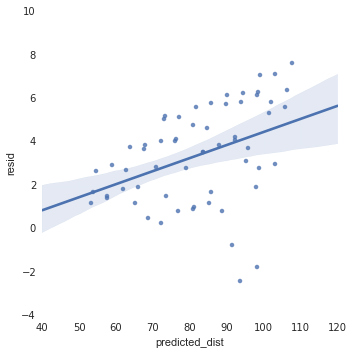

In [196]:
#training.plot(x='predicted_dist', y='resid', kind="scatter", )
#plt.scatter(training.predicted_dist, training.resid )
sns.lmplot("predicted_dist", "resid" , data=training, )

In [197]:
focal_length = 29. #mm
sensor_size = 4.8 # mm
# http://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo
def easy_way(x_diff, pitcher_catcher_dist, h=0): 
    distmm= (focal_length *304.8* pitcher_catcher_dist * PIC_LENGTH) / (x_diff * sensor_size)
    distft= distmm / 304.8
    dist_correctedh = sqrt(distft**2 - h**2)
    
    #tangent_correction = sqrt(dist_correctedh**2 - (pitcher_catcher_dist / 2.)**2)
    #return tangent_correction
    return dist_correctedh

training['easy_way_est'] = training.xdiff.apply(lambda x: easy_way(x, PITCHER_CATCHER_DISTANCE))
training['easy_resid'] = training.easy_way_est - training.distance_ft
training['easy_way_est**2'] = training.easy_way_est**2
training['pitcher_catcher_distance'] = PITCHER_CATCHER_DISTANCE

In [198]:
easy_res = training[['xmin','easy_way_est', 'distance_ft', 'easy_resid']]

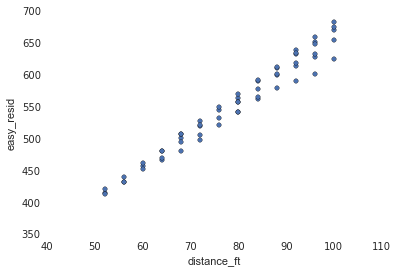

In [199]:
training.plot(x='distance_ft', y='easy_resid', kind="scatter")

In [211]:
training['xmin**2'] = training.xmin**2
training['xmin**4'] = training.xmin**4
training['xmin**6'] = training.xmin**6
#reg = pd.stats.ols.OLS(y=training.distance_ft, x=training[['easy_way_est','easy_way_est**2', 'xmin','xmin**2']])
reg = pd.stats.ols.OLS(y=training.distance_ft, x=training[['predicted_dist','predicted_dist**2', 'xmin**2','xmin']])
reg = pd.stats.ols.OLS(y=training.distance_ft, x=training[['predicted_dist', 'xmin**2','xmin']])
training['fitted_pred'] = reg.y_fitted
training['fitted_resid'] = training.fitted_pred - training.distance_ft

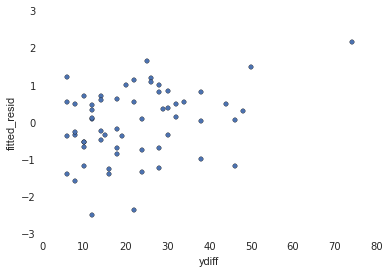

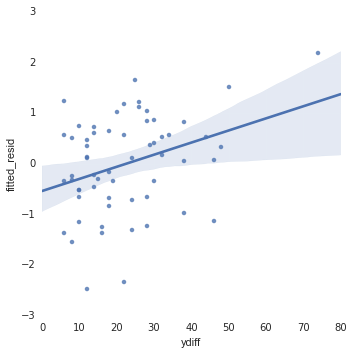

In [218]:
training.plot(x='ydiff', y='fitted_resid', kind='scatter')
sns.lmplot('ydiff', 'fitted_resid', data=training)

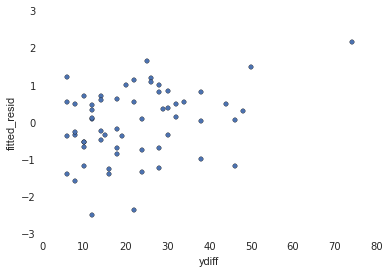

In [202]:
training.plot(x='ydiff', y='fitted_resid', kind='scatter')

In [203]:
training.fitted_resid.mean()

-1.4992451724538115e-13

TEST

In [204]:
test_dat = pd.read_excel('/Users/brianritz/projects/findball/distance_calibration/photos_20160211/photo_info.xlsx')
test_dat = test_dat[test_dat.photo_no !=71]
test_dat['xdiff']= test_dat.xmax - test_dat.xmin

test_dat['ydiff'] = test_dat.apply(lambda x: (x.ymax - x.ymin) * (-1 + 2*int(x.direction[0:4]=="up")), axis=1)
test_dat['xmin**2'] = test_dat.xmin**2
test_dat['xmin**4'] = test_dat.xmin**4

In [205]:
test_dat.loc[:,'predicted_dist'] = test_dat.apply(lambda x: more_complex(x.xdiff, x.ydiff, pitcher_catcher_distance=PITCHER_CATCHER_DISTANCE, s=0, h=H), axis=1)
#test_dat['predicted_dist'] = pd.Series(all_pred)
test_dat.loc[:,'predicted_dist**2'] = test_dat.predicted_dist**2

test_dat['resid'] = test_dat.predicted_dist - test_dat.distance_ft

test_dat['easy_way_est'] = test_dat.xdiff.apply(lambda x: easy_way(x, PITCHER_CATCHER_DISTANCE))
test_dat['easy_resid'] = test_dat.easy_way_est - test_dat.distance_ft
test_dat['easy_way_est**2'] = test_dat.easy_way_est**2

In [207]:
test_dat['fitted_pred'] = reg.predict(x=test_dat[['predicted_dist','xmin**2','xmin']])
test_dat['fitted_resid'] = test_dat.fitted_pred - test_dat.distance_ft

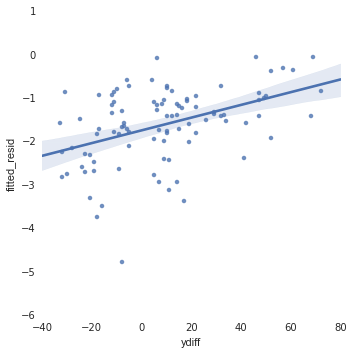

In [216]:
sns.lmplot('ydiff', 'fitted_resid', data=test_dat)

In [93]:
test_dat.head()

,photo_no,distance_ft,direction,xmin,ymin,xmax,ymax,xdiff,ydiff,xmin**2,xmin**4,predicted_dist,resid,easy_way_est,easy_resid,easy_way_est**2,predicted_dist**2,fitted_pred,fitted_resid
0,0,100,up,507,1307,1978,1321,1471,14,257049,6.607419e+10,103.238857,3.238857,99.850385,-0.149615,9970.099326,10658.261681,97.144563,-2.855437
1,1,100,up,460,1316,1936,1327,1476,11,211600,4.477456e+10,102.822212,2.822212,99.485073,-0.514927,9897.279805,10572.407238,96.956590,-3.043410
2,2,100,down,266,1322,1781,1330,1515,-8,70756,5.006412e+09,99.658591,-0.341409,96.715075,-3.284925,9353.805792,9931.834779,95.093870,-4.906130
3,3,100,up,449,1232,1929,1249,1480,17,201601,4.064296e+10,102.490747,2.490747,99.194530,-0.805470,9839.554794,10504.353238,96.704472,-3.295528
4,4,98,down,799,1215,2270,1223,1471,-8,638401,4.075558e+11,103.238857,5.238857,99.850385,1.850385,9970.099326,10658.261681,96.578242,-1.421758


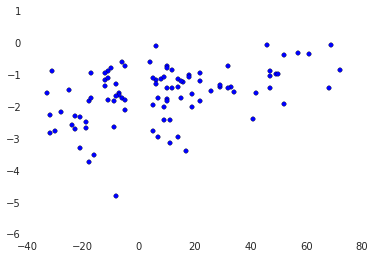

In [213]:
plt.scatter(test_dat.ydiff, test_dat.fitted_resid)

In [220]:
test_dat[test_dat.fitted_resid<-4]

,photo_no,distance_ft,direction,xmin,ymin,xmax,ymax,xdiff,ydiff,xmin**2,xmin**4,easy_way_est,easy_resid,easy_way_est**2,fitted_pred,fitted_resid
2,2,100,down,266,1322,1781,1330,1515,-8,70756,5006411536,100.747723,0.747723,10150.103644,95.101713,-4.898287


In [221]:
test_dat[test_dat.distance_ft==100]

,photo_no,distance_ft,direction,xmin,ymin,xmax,ymax,xdiff,ydiff,xmin**2,xmin**4,easy_way_est,easy_resid,easy_way_est**2,fitted_pred,fitted_resid
0,0,100,up,507,1307,1978,1321,1471,14,257049,66074188401,103.761251,3.761251,10766.397178,97.117436,-2.882564
1,1,100,up,460,1316,1936,1327,1476,11,211600,44774560000,103.409756,3.409756,10693.577656,96.934032,-3.065968
2,2,100,down,266,1322,1781,1330,1515,-8,70756,5006411536,100.747723,0.747723,10150.103644,95.101713,-4.898287
3,3,100,up,449,1232,1929,1249,1480,17,201601,40642963201,103.130270,3.130270,10635.852646,96.686032,-3.313968


use just the second time to estimate coefficients

In [141]:
import numpy as np
from sklearn.cross_validation import StratifiedShuffleSplit
X = test_dat.drop('distance_ft', axis=1)
y = test_dat['distance_ft']

split = StratifiedShuffleSplit(y, n_iter=1, test_size=0.5, random_state=0)

for train_index, test_index in split:
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
   y_train, y_test = y[train_index], y[test_index]


#X_train, X_test, y_train, y_test = train_test_split(test_dat.drop('distance_ft'), test_dat.distance_ft, test_size=0.5, random_state=42)

('TRAIN:', array([35, 74, 49, 81, 48, 41, 12, 50,  9, 91,  5, 61,  3, 17, 55, 77, 87,
       64, 62, 70, 53, 43, 46,  2,  7, 78, 37, 36, 25, 92, 27, 66, 30, 84,
       85, 15, 56, 72, 11, 67, 95, 45, 60, 75, 20, 32, 19, 21,  6, 94, 38,
       14]), 'TEST:', array([42, 79, 10, 54, 34, 40, 69, 83, 39, 28, 68, 47, 18, 63, 33, 82,  4,
       58, 13,  1, 80, 71, 29, 88, 89,  0, 24, 26, 59, 52, 22, 65, 57, 86,
       31, 16, 23, 90, 44, 73, 93, 76, 51,  8]))


In [161]:
reg = pd.stats.ols.OLS(y=y_train, x=X_train[['predicted_dist','predicted_dist**2','xmin**2', 'xmin**4','xmin']])
X_train.loc['fitted_pred',:] = reg.predict(x=X_train[['predicted_dist','predicted_dist**2','xmin**2', 'xmin**4','xmin']])
reg = pd.stats.ols.OLS(y=y_train, x=X_train[['predicted_dist','predicted_dist**2']])
X_train.loc['fitted_pred',:] = reg.predict(x=X_train[['predicted_dist','predicted_dist**2']])
X_train.loc['fitted_resid',:] = X_train.fitted_pred - y_train
reg

/Users/brianritz/.virtualenvs/findball/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <predicted_dist> + <predicted_dist**2> + <intercept>

Number of Observations:         44
Number of Degrees of Freedom:   3

R-squared:         0.9922
Adj R-squared:     0.9919

Rmse:              1.2367

F-stat (2, 41):  2621.1516, p-value:     0.0000

Degrees of Freedom: model 2, resid 41

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
predicted_dist     0.6801     0.1391       4.89     0.0000     0.4076     0.9527
predicted_dist**2     0.0016     0.0009       1.86     0.0707    -0.0001     0.0034
     intercept    12.6739     5.3507       2.37     0.0226     2.1865    23.1613
---------------------------------End of Summary---------------------------------

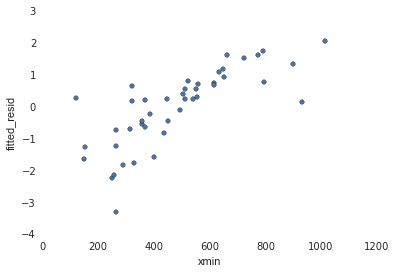

In [163]:
X_train.plot(x='xmin', y='fitted_resid', kind='scatter')

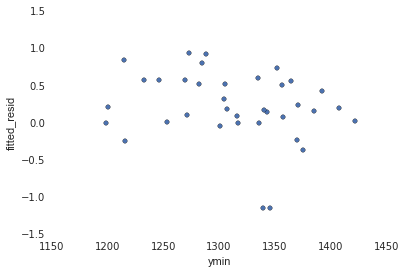

In [157]:
X_test.loc['fitted_pred',:] = reg.predict(x=X_test[['predicted_dist','predicted_dist**2','xmin**2', 'xmin**4','xmin']])
X_test.loc['fitted_resid',:] = X_test.fitted_pred - y_test
X_test.plot(x='ymin', y='fitted_resid', kind='scatter')